# Name Collection

In [ ]:
!wget https://raw.githubusercontent.com/ygtxr1997/CelebBasis/main/infer_images/wiki_names.txt

In [ ]:
!wget https://raw.githubusercontent.com/ygtxr1997/CelebBasis/main/infer_images/celebs.txt

In [ ]:
#%pip install scikit-learn diffusers pillow torch umap-learn timm

In [2]:
from pathlib import Path
from diffusers import StableDiffusionPipeline
import torch
import diffusers
import time
import torch
import matplotlib.pyplot as plt
import PIL
import numpy as np
import gc

In [2]:
#with Path('wiki_names.txt').open() as f:
with Path('celebs.txt').open() as f:
    wiki_names = f.read().split('\n')

len(wiki_names) # 1109

first_names = [n for n in set([name.split(' ')[0] for name in wiki_names]) if '.' not in n]
last_names = [n for n in set([name.split(' ')[-1] for name in wiki_names]) if '.' not in n]

len(first_names), len(last_names)

(107, 110)

# Image Generation

In [3]:
model_id = "CompVis/stable-diffusion-v1-4"

pipe = StableDiffusionPipeline.from_pretrained(
                model_id,
                revision="fp16",
                #torch_dtype=torch.float16,
                #use_auth_token=True
            ).to('cuda')

# https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0/blob/main/scheduler/scheduler_config.json
true, false, null = True, False, None
pipe.scheduler = diffusers.EulerDiscreteScheduler(
    **{
      "beta_end": 0.012,
      "beta_schedule": "scaled_linear",
      "beta_start": 0.00085,
      "interpolation_type": "linear",
      "num_train_timesteps": 1000,
      "prediction_type": "epsilon",
      "steps_offset": 1,
      "timestep_spacing": "leading",
      "trained_betas": null,
      "use_karras_sigmas": false
    }
)

# disable safety checker

#pipe.requires_safety_checker=False
def passthrough(images, *args, **kargs):
    return images, [False for _ in images]
pipe.safety_checker = passthrough

text_encoder/model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/home/dmarx/.local/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [ ]:
# 1. loop over names
# 2. create folder for names
# 3. generate images, save to folder
# 4. compute CLIP/DINO image embeddings, save to folder

# ---

# let's start with 10 names and prototype this procedure generally.
# an important hyper parameter to start with will be the number of images per name.
# let's start by generating an unnecessary number of images for this first group, say 20-100.
# then use these to compute our diversity measures, and calibrate how many images we need by how many images it generally takes to get this measure to converge.


In [ ]:
# RUN THIS CELL TO GENERATE IMAGES

names = first_names

kwargs = dict(
    num_inference_steps=25,
    num_images_per_prompt= 12 # 16 # oh nice, i just assumed that would OOM # 8
)

root = Path("images")

#images_per_prompt = 24 #40
#images_per_prompt = 64
# fuck it.
images_per_prompt = 128

for name in names:
    print(name)
    prompt = f"a photo of {name}, portrait photography, full color, face full frame"
    prompt = prompt.lower().strip()
    
    prompt_clean = prompt.replace(',','')
    outdir = root / prompt_clean.replace(' ','_')  
    outdir.mkdir(parents=True, exist_ok=True)
    while len(list(outdir.glob('*.png'))) < images_per_prompt:
        outv = pipe(prompt, **kwargs)
        #if any(outv.nsfw_content_detected):
        #    #continue
        #    break

        for idx,im in enumerate(outv.images):
            # would prefer to name images by seed, but hf is makes it hard.
            fname = outdir / f"{int(time.time())}_{idx}.png" 
            im.save(fname)


In [ ]:
# let's generate a shit load of images 
# for a few high-bias names as a calibration control
# for sensitivity analysis.

high_bias_names = [
    "oprah",
    "keanu",
    "cher",
    "beyoncé",
    "shaquille",
    "rihanna",
    "anupam",
]

images_per_prompt = 200


for name in high_bias_names:
    print(name)
    prompt = f"a photo of {name}, portrait photography, full color, face full frame"
    prompt = prompt.lower().strip()
    
    prompt_clean = prompt.replace(',','')
    outdir = root / prompt_clean.replace(' ','_')  
    outdir.mkdir(parents=True, exist_ok=True)
    while len(list(outdir.glob('*.png'))) < images_per_prompt:
        outv = pipe(prompt, **kwargs)
        #if any(outv.nsfw_content_detected):
        #    #continue
        #    break

        for idx,im in enumerate(outv.images):
            # would prefer to name images by seed, but hf is makes it hard.
            fname = outdir / f"{int(time.time())}_{idx}.png" 
            im.save(fname)

In [5]:
# free up memory
del pipe
gc.collect()
torch.cuda.empty_cache()

# Image embedding

## DINO

In [74]:
#del dinov2_vits14
if 'backbone_model' in locals():
    del backbone_model
#del pipe
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:

#dinov2_vitb14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
#dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')

#backbone_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
#emb_suffix = ".dinov2_cls.embed"

backbone_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')
emb_suffix = ".dinov2_vitg14_cls.embed"


backbone_model.eval()
backbone_model.cuda()

In [98]:
#im.getexif()

# x = torch.tensor(np.array(im.resize([560,560]))).unsqueeze(0).cuda()
# x=x.transpose(3,1)
# x=x.float()

In [99]:
# TODO: would be nice if images were of some size that
# had 8 and 14 as a common factor.
# 560 x 560 is probably a good option.
# 896 would also have 64 as a common factor.

#outv = backbone_model.forward_features(x)
#outv.keys()

dict_keys(['x_norm_clstoken', 'x_norm_patchtokens', 'x_prenorm', 'masks'])

In [104]:
# for k in outv.keys():
#     if outv[k] is not None:
#         print((k,outv[k].shape))
        
# # ('x_norm_clstoken', torch.Size([1, 384]))
# # ('x_norm_patchtokens', torch.Size([1, 1600, 384]))
# # ('x_prenorm', torch.Size([1, 1601, 384]))

('x_norm_clstoken', torch.Size([1, 384]))
('x_norm_patchtokens', torch.Size([1, 1600, 384]))
('x_prenorm', torch.Size([1, 1601, 384]))


In [7]:
# run through images in a folder, project each into the clstoken and persist

def image2dino(image):
    # prep image
    x = torch.tensor(np.array(image.resize([560,560]))).unsqueeze(0).cuda()
    x=x.transpose(3,1)
    x=x.float()
    
    # project
    outv = backbone_model.forward_features(x)
    return outv['x_norm_clstoken']

#embed = image2dino(im)
#embed.shape

In [ ]:
# RUN THIS CELL TO GENERATE DINO EMBEDS

# 1. glob images from folder
# 2. load iamge
# 3. project image
# 4. construct outname from inname
# 5. persist embed





errors = []

for fpath in Path('images').rglob('*'):
    if not fpath.is_dir():
        continue
    if 'full_frame' not in str(fpath):
        continue
    if '.ipynb_checkpoints' in str(fpath):
        continue
    outdir = fpath
    
    print(outdir)


    image_paths = outdir.glob('*.png')
    # glob embeds, only project images that we haven't already embedded
    embed_paths = [str(p) for p in outdir.glob(f"{emb_suffix}.npy")]
    
    with torch.no_grad():
        for fpath in image_paths:
            # skip images we've already embedded
            embed_path = outdir / (fpath.stem + emb_suffix)
            if str(embed_path) in embed_paths:
                continue
            try:
                im = PIL.Image.open(fpath)
                embed = image2dino(im)
            # some weird PIL error on 
            except:
                errors.append(fpath)
                continue
            
            #torch.save(embed, embed_path) # 2.3mb for a 1x384 vector? wtf?
            arr = np.array(embed.cpu())
            # 1kb instead of 2mb
            np.save(embed_path, arr) # adds ".npy" extension. whatever.

print(errors)

## unCLIP Embedding

TODO

## CLIP Embedding

In [5]:
emb_suffix = ".clip_vitb32_laion2b_s34b_b79k.embed"

In [5]:
# TODO

# https://github.com/mlfoundations/open_clip/

# pip install open_clip_torch

import torch
from PIL import Image
import open_clip

emb_suffix = ".clip_vitb32_laion2b_s34b_b79k.embed"
clip_model, _, clip_preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')

# # I think this is the one SD is actually using
# # ('ViT-L-14', 'openai'),
# emb_suffix = ".clip_vitl14_openai.embed"
# clip_model, _, clip_preprocess = open_clip.create_model_and_transforms(
#     'ViT-L-14', pretrained='openai')
# # this model is just slow af. not worth it. too chonky. vitb32 clearly does the job.

# not working...
## apparently 'EVA02-E-14-plus', 'laion2b_s9b_b144k' is the new hotness
#emb_suffix = ".clip_EVA02-E-14-plus_laion2b_s9b_b144k.embed"
#clip_model, _, clip_preprocess = open_clip.create_model_and_transforms(
#    'EVA02-E-14-plus', 
#    pretrained='laion2b_s9b_b144k')


# # 'EVA02-L-14-336', 'merged2b_s6b_b61k'),
# emb_suffix = ".clip_EVA02-L-14-336_merged2b_s6b_b61k.embed"
# clip_model, _, clip_preprocess = open_clip.create_model_and_transforms(
#    'EVA02-L-14-336', 
#    pretrained='merged2b_s6b_b61k')


#image = Image.open("CLIP.png")
#image = im

# image = preprocess(image).unsqueeze(0)

# #tokenizer = open_clip.get_tokenizer('ViT-B-32')
# #text = tokenizer(["a diagram", "a dog", "a cat"])

# with torch.no_grad(), torch.cuda.amp.autocast():
#     image_features = model.encode_image(image)
#     image_features /= image_features.norm(dim=-1, keepdim=True)
#     #text_features = model.encode_text(text)
#     #text_features /= text_features.norm(dim=-1, keepdim=True)
#     #text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
#     #print("Label probs:", text_probs)  # prints: [[1., 0., 0.]]


def image2clip(image):
    image = clip_preprocess(image).unsqueeze(0)
    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = clip_model.encode_image(image)
        #image_features /= image_features.norm(dim=-1, keepdim=True)
    return image_features

100%|███████████████████████████████████████| 933M/933M [02:11<00:00, 7.09MiB/s]


In [ ]:
# RUN THIS CELL TO GENERATE CLIP EMBEDS

# 1. glob images from folder
# 2. load iamge
# 3. project image
# 4. construct outname from inname
# 5. persist embed


errors = []

for fpath in Path('images').rglob('*'):
    if not fpath.is_dir():
        continue
    if 'full_frame' not in str(fpath):
        continue
    if '.ipynb_checkpoints' in str(fpath):
        continue
    outdir = fpath
    
    print(outdir)


    image_paths = outdir.glob('*.png')
    # glob embeds, only project images that we haven't already embedded
    embed_paths = [str(p) for p in outdir.glob(f"{emb_suffix}.npy")]
    
    with torch.no_grad():
        for fpath in image_paths:
            # skip images we've already embedded
            embed_path = outdir / (fpath.stem + emb_suffix)
            if str(embed_path) in embed_paths:
                continue
            try:
                im = PIL.Image.open(fpath)
                #embed = image2dino(im)
                embed = image2clip(im)
            # some weird PIL error on 
            except:
                errors.append(fpath)
                continue
            
            #torch.save(embed, embed_path) # 2.3mb for a 1x384 vector? wtf?
            arr = np.array(embed.cpu())
            # 1kb instead of 2mb
            np.save(embed_path, arr) # adds ".npy" extension. whatever.

print(errors)

# Diversity Measurement

In [12]:
outdir

PosixPath('images/a_photo_of_brian_portrait_photography_full_color_face_full_frame/.ipynb_checkpoints')

In [91]:
# CONVERGENCE CALIBRATION SMOKE TEST

# 1. load embeddings
# 2. compute cumulative variance
# 3. plot variance convergence

outdir = Path("images/a_photo_of_oprah_portrait_photography_full_color_face_full_frame")

#embed_paths = outdir.glob('*.embed.*')
embed_paths = [str(p) for p in outdir.glob(f"*{emb_suffix}.npy")]
embeds = []
for fpath in embed_paths:
    embed = np.load(fpath)
    # normalize
    embed /= np.linalg.norm(embed)
    embeds.append(embed)

#V = []
S = []
#D = []
for i in range(3, len(embeds)+1):
    x = np.concatenate(embeds[:i]) #.shape
#     # variance
#     cv = np.cov(x.T)
#     v = np.trace(cv) / cv.shape[-1]
#     V.append(v)
    
#     (sign, logabsdet) = np.linalg.slogdet(cv)
#     #D.append(logabsdet)
#     D.append(logabsdet / i)
    
    # centroid similarity
    mu = x.mean(0)
    similarities = x@mu
    S.append(similarities.mean())
    

In [20]:
len(S)

198

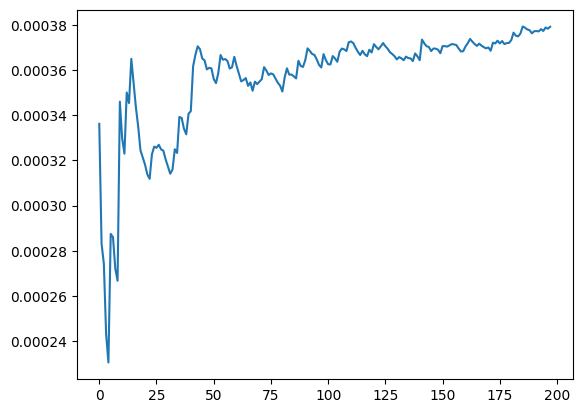

In [160]:
#plt.plot(V)
# variance converging, but increasing? 
# maybe it just looks this way for that one example

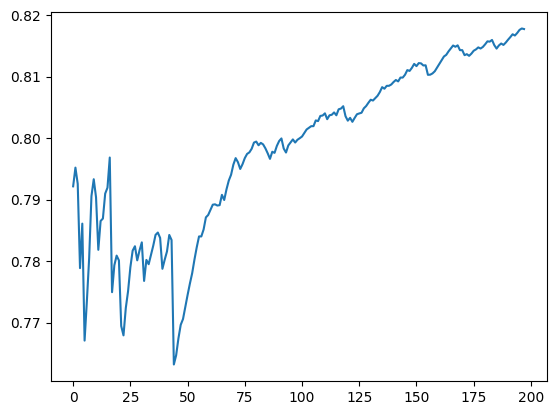

In [92]:
plt.plot(S)

In [ ]:
# i wonder if this upward movement has to do with the stability of the 
# mean vector?
#
# considering this is probably going to be a measure on the bias in CLIP, 
# maybe it makes sense to use the CLIP text embedding as the class centroid?

# or alternatively, instead of a centroid maybe I should use medioid? 
# might result in some "stair step" behavior as medioid changes with
# number of observations being interrogated

In [ ]:
# TODO: add a CI lower bound to account for # images used for summary

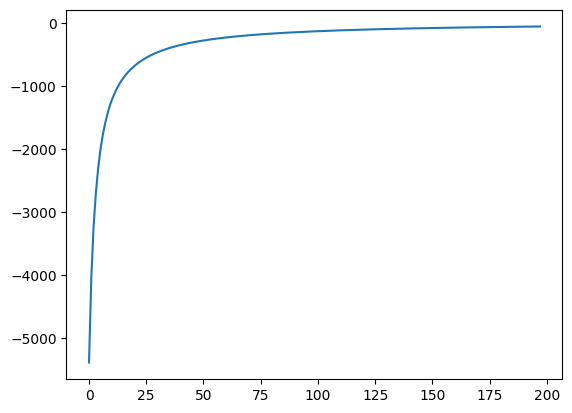

In [176]:
#plt.plot(D) # well, at least it's pretty. too smooth. sus af.

In [6]:
# LOAD EMBEDDINGS

# 1. iterate over folders
# 2. compute summary for prompt
# 3. rank prompts by summary statistic
# 4. bin ranges, plot a few samples in each range

from copy import deepcopy

# enforce same # embeddings for all
n = 128

prompt_diversity = {}
embeds_cache = {}
similarities_cache = {}
for fpath in Path('images').rglob('*'):
    if not fpath.is_dir():
        continue
    if 'full_frame' not in str(fpath):
        continue
    outdir = fpath

    embed_paths = list(outdir.glob(f"*{emb_suffix}.npy"))

    # constrain attention to names we have some threshold number of images for
    if not len(embed_paths) >= 64:
        continue
    
    embeds = []
    for fpath in embed_paths[:n]:
        embed = np.load(fpath)
        # normalize
        embed /= np.linalg.norm(embed)
        embeds.append(embed)

        
        
#     S = []
#     for i in range(3, len(embeds)+1):
#         x = np.concatenate(embeds[:i])

#         # centroid similarity
#         mu = x.mean(0)
#         similarities = x@mu
#         S.append(similarities.mean())
    x = np.concatenate(embeds)
    mu = x.mean(0)
    distances = x@mu
    #similarities = 1 - distances
    similarities = distances
    diversity_score = similarities.mean()
    #print(outdir)
    #print((diversity_score, len(embeds)))
    prompt_diversity[str(outdir)] = diversity_score
    embeds_cache[str(outdir)] = deepcopy(embeds)
    similarities_cache[str(outdir)] = deepcopy(similarities)

In [7]:
# clip-vitb32
# inverted... maybe i shouldn't have "1 - x"-ed the DINO experiments
from collections import Counter
Counter(prompt_diversity).most_common()

[('images/a_photo_of_rihanna_portrait_photography_full_color_face_full_frame',
  0.8535631),
 ('images/a_photo_of_kanye_portrait_photography_full_color_face_full_frame',
  0.8489454),
 ('images/a_photo_of_beyoncé_portrait_photography_full_color_face_full_frame',
  0.82243407),
 ('images/a_photo_of_madonna_portrait_photography_full_color_face_full_frame',
  0.81165856),
 ('images/a_photo_of_oprah_portrait_photography_full_color_face_full_frame',
  0.804036),
 ('images/a_photo_of_meera_portrait_photography_full_color_face_full_frame',
  0.77760863),
 ('images/a_photo_of_adele_portrait_photography_full_color_face_full_frame',
  0.7641853),
 ('images/a_photo_of_himesh_portrait_photography_full_color_face_full_frame',
  0.74994487),
 ('images/a_photo_of_amita_portrait_photography_full_color_face_full_frame',
  0.73699784),
 ('images/a_photo_of_hailee_portrait_photography_full_color_face_full_frame',
  0.7337523),
 ('images/a_photo_of_yuvraj_portrait_photography_full_color_face_full_frame',


In [26]:
# vits
from collections import Counter
Counter(prompt_diversity).most_common()

[('images/a_photo_of_rihanna_portrait_photography_full_color_face_full_frame',
  0.21635216),
 ('images/a_photo_of_keanu_portrait_photography_full_color_face_full_frame',
  0.21444821),
 ('images/a_photo_of_madonna_portrait_photography_full_color_face_full_frame',
  0.18700051),
 ('images/a_photo_of_amita_portrait_photography_full_color_face_full_frame',
  0.17956606),
 ('images/a_photo_of_yuvraj_portrait_photography_full_color_face_full_frame',
  0.17655411),
 ('images/a_photo_of_kanye_portrait_photography_full_color_face_full_frame',
  0.16864416),
 ('images/a_photo_of_steven_portrait_photography_full_color_face_full_frame',
  0.16478685),
 ('images/a_photo_of_kobe_portrait_photography_full_color_face_full_frame',
  0.1628157),
 ('images/a_photo_of_sung_portrait_photography_full_color_face_full_frame',
  0.16138422),
 ('images/a_photo_of_elon_portrait_photography_full_color_face_full_frame',
  0.16125277),
 ('images/a_photo_of_celina_portrait_photography_full_color_face_full_frame',


In [80]:
# vitg
from collections import Counter
Counter(prompt_diversity).most_common()

[('images/a_photo_of_dalip_portrait_photography_full_color_face_full_frame',
  0.14526153),
 ('images/a_photo_of_leonardo_portrait_photography_full_color_face_full_frame',
  0.14496842),
 ('images/a_photo_of_amita_portrait_photography_full_color_face_full_frame',
  0.14418498),
 ('images/a_photo_of_kunal_portrait_photography_full_color_face_full_frame',
  0.14275335),
 ('images/a_photo_of_kanye_portrait_photography_full_color_face_full_frame',
  0.14112502),
 ('images/a_photo_of_neymar_portrait_photography_full_color_face_full_frame',
  0.13897611),
 ('images/a_photo_of_yuvraj_portrait_photography_full_color_face_full_frame',
  0.13598435),
 ('images/a_photo_of_naga_portrait_photography_full_color_face_full_frame',
  0.13567993),
 ('images/a_photo_of_rihanna_portrait_photography_full_color_face_full_frame',
  0.13549587),
 ('images/a_photo_of_dante_portrait_photography_full_color_face_full_frame',
  0.13526),
 ('images/a_photo_of_shaquille_portrait_photography_full_color_face_full_fram

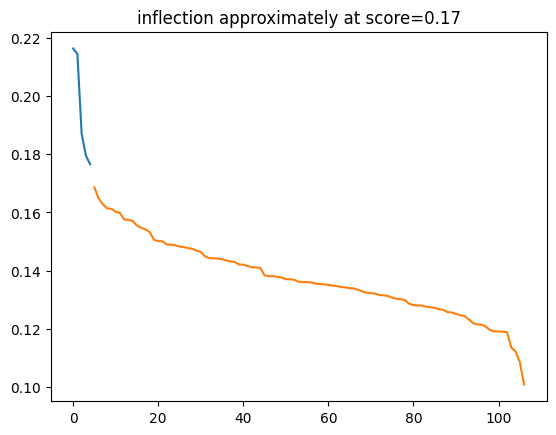

In [27]:
# vits
scores = [v for k,v in Counter(prompt_diversity).most_common()]
scores = np.array(scores)
xv = np.arange(len(scores))
thresh = 0.17
plt.plot(xv[scores>thresh], scores[scores>thresh]) # inflection point score==0.17
plt.plot(xv[scores<=thresh], scores[scores<=thresh])
plt.title(f"inflection approximately at score={thresh}")
plt.show()

seems like a reasonable cutoff from the plot and spot checking the associated names, but a very conspicuous miss is `elon`, which has me concerned this isn't a sufficient measure for distinguishing strong identities (of which "elon" certainly qualifies).

Ditto `Oprah`, `Lebron`, `Shaquille`

I suspect I could improve results some by generating more images, but what I've generated already should be sufficient to differentiate identies. 

Another small "cheat" could be to drop outliers before computing the summary statistics. That's def way easier than generating a bunch of images. 

Another approach could be to try training a bias-focusing encoder, following through on the "identity-preserving contrastive loss" idea. 

---

Maybe I need to just consider two identity buckets, and the `(.13,.17)` bucket has something substantively different about its representation that permits more diversity in the outputs? Maybe the ultra high similarity identities are my overfitted subset?

Tried generating more images, didn't significantly change results. still need to experiment with dropping outliers. Additionally, could just work with this as is. 

Also tried using the richer embedding space of the DINO-vitg model (below), looks like the smaller model is actually better for more current purposes here. Could always try an intermediate model.

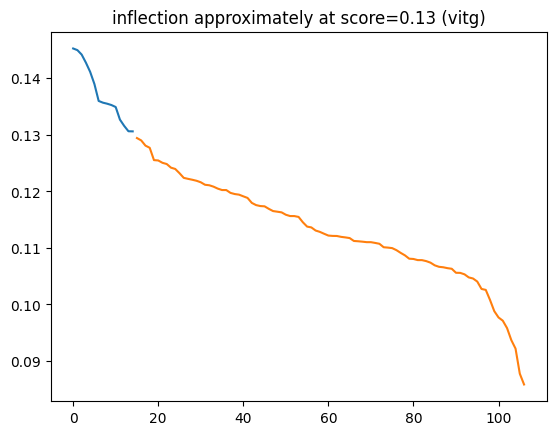

In [81]:
scores = [v for k,v in Counter(prompt_diversity).most_common()]
scores = np.array(scores)
xv = np.arange(len(scores))
thresh = 0.13
plt.plot(xv[scores>thresh], scores[scores>thresh]) # inflection point score==0.17
plt.plot(xv[scores<=thresh], scores[scores<=thresh])
plt.title(f"inflection approximately at score={thresh} (vitg)")
plt.show()

larger capacity of vitg has more "supplementary" information that isn't communicating attributes relevant to identity representation, cluster similarity less effective. either need more images or "bias crystallization" with an encoder. try to learn a reduced rank representation from DINO that only preserves the information salient to differentiating identities.

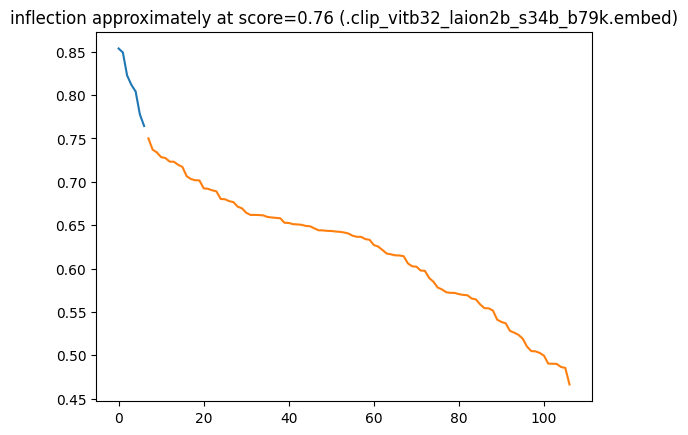

In [98]:
# clip-vitb32
scores = [v for k,v in Counter(prompt_diversity).most_common()]
scores = np.array(scores)
xv = np.arange(len(scores))
thresh = 0.76
plt.plot(xv[scores>thresh], scores[scores>thresh]) # inflection point score==0.17
plt.plot(xv[scores<=thresh], scores[scores<=thresh])
plt.title(f"inflection approximately at score={thresh} ({emb_suffix})")
plt.show()

# Data Exploration Sandbox

Fuck it. tSNE.

In [8]:
embeds = []
classes = []
for i, embeds_i in enumerate(embeds_cache.values()):
    embeds.extend(embeds_i)
    classes.extend([i]*len(embeds_i))

len(embeds), len(classes), len(set(classes))

(13696, 13696, 107)

In [9]:
embeds = np.array([e.ravel() for e in embeds])

In [10]:
#embeds = []
inclass_similarities = []
#classes = []
for i, score_i in enumerate(similarities_cache.values()):
    inclass_similarities.extend(score_i)
    #classes.extend([i]*len(score_i))

len(inclass_similarities), len(classes), len(set(classes))


# collect
# reduce dimension
# plot 2d
# plot 3d (what widget?)


(13696, 13696, 107)

In [12]:
embeds.shape

(13696, 512)

In [87]:
# fuck it, let's learn an SVM. 
# see which embeddings are more "identity preserving"

import sklearn
from sklearn import svm

# lol... maybe i should use rapids 
# or figure out how to leverage gpu w sklearn

#discriminator = sklearn.svm.SVC()
discriminator = svm.SVC()
discriminator.fit(embeds, arr_classes.ravel())

SVC()

In [88]:
dir(discriminator)

['C',
 '__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_feature_names',
 '_check_n_features',
 '_check_proba',
 '_class_weight',
 '_compute_kernel',
 '_decision_function',
 '_dense_decision_function',
 '_dense_fit',
 '_dense_predict',
 '_dense_predict_proba',
 '_dual_coef_',
 '_estimator_type',
 '_gamma',
 '_get_coef',
 '_get_param_names',
 '_get_tags',
 '_impl',
 '_intercept_',
 '_more_tags',
 '_n_support',
 '_num_iter',
 '_parameter_constraints',
 '_probA',
 '_probB',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_sparse',
 '_sparse_decision_function',
 '_

In [ ]:
# https://stackoverflow.com/a/41601281/819544
from matplotlib import pyplot as plt
from sklearn import svm

def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

#features_names = ['input1', 'input2']
#svm = svm.SVC(kernel='linear')
#svm.fit(X, Y)
f_importances(svm.coef_, features_names)

# lol... what was even the point of this. 2hi4this
# let's just torch it, who am i kidding. i want an encoder.

In [90]:
embeds.shape

(7801, 1536)

In [33]:
# oh right, i still haven't even tsne'd it.

import sklearn.manifold
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd


tsne = TSNE(
    n_components=2
    ,learning_rate='auto'
    ,init='random'
    ,perplexity= 15 # 3 # 40 
    ,n_iter=500 # 3000
)
x_tsne = tsne.fit_transform(embeds)

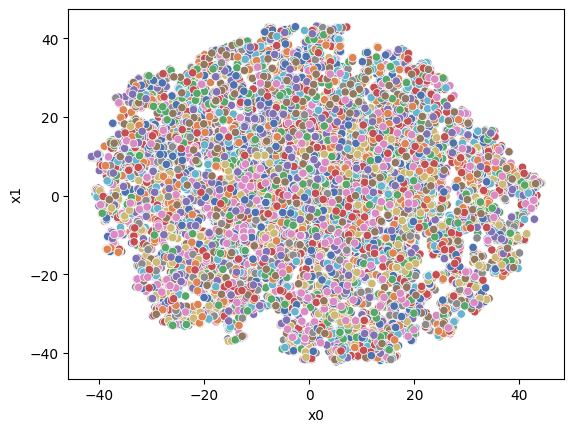

In [34]:
# vits

df = pd.DataFrame(
    {
        'x0':x_tsne[:,0], 
        'x1':x_tsne[:,1], 
        'class_id':classes,
        'prior-adherence':inclass_similarities,
    })
sns.scatterplot(
    df, 
    x='x0', 
    y='x1', 
    hue='class_id', 
    #alpha='prior-adherence',
    palette="deep")
ax=plt.gca()
ax.get_legend().remove()
plt.show()

# TODO: use per-class summary score as hue for all points in that class


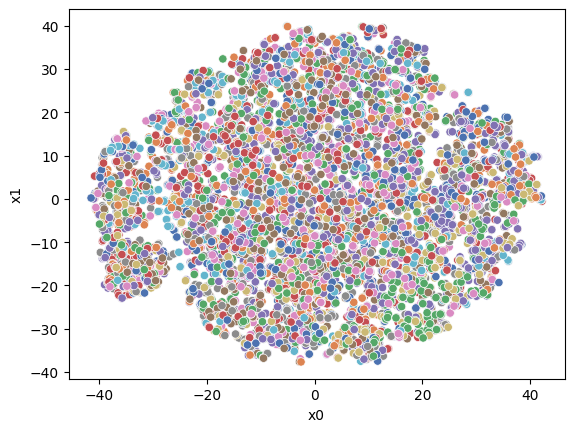

In [118]:

df = pd.DataFrame(
    {
        'x0':x_tsne[:,0], 
        'x1':x_tsne[:,1], 
        'class_id':classes,
        'prior-adherence':inclass_similarities,
    })
sns.scatterplot(
    df, 
    x='x0', 
    y='x1', 
    hue='class_id', 
    #alpha='prior-adherence',
    palette="deep")
ax=plt.gca()
ax.get_legend().remove()
plt.show()

# TODO: use per-class summary score as hue for all points in that class


In [ ]:
# https://umap.scikit-tda.org/supervised.html#using-labels-to-separate-classes-supervised-umap

In [121]:
import umap

In [122]:
%%time
umap_nn20 = umap.UMAP(n_neighbors=20)
umap_embeds_nn20 = umap_nn20.fit_transform(embeds, y=classes)

/home/dmarx/.local/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


CPU times: user 1min 35s, sys: 2.17 s, total: 1min 38s
Wall time: 18.2 s


In [123]:
umap_embeds_nn20.shape

(7801, 2)

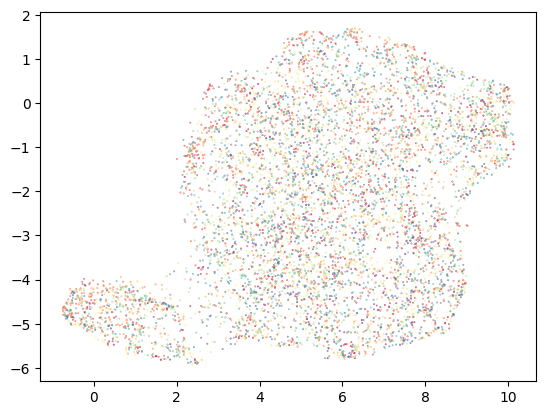

In [124]:
plt.scatter(
    *umap_embeds_nn20.T,
    s=0.1, 
    c=classes,
    cmap='Spectral',
    alpha=1.0)
plt.show()
# I wonder if maybe I could get explicit with distances, 
# and just use inter-cluster for observations,
# and also do centroids and cluster inter-centroid distances
# ... that'd be cheating, but it'd be informative at least.

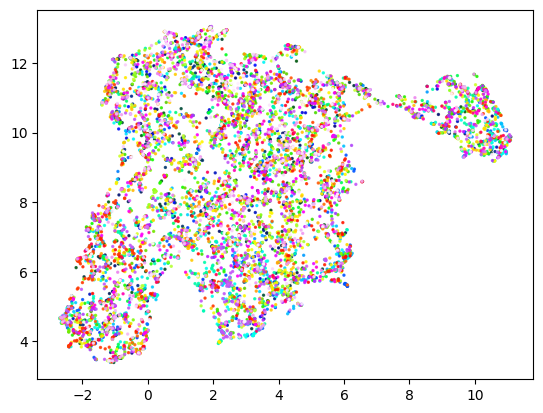

CPU times: user 50.1 s, sys: 1.85 s, total: 51.9 s
Wall time: 4.02 s


In [151]:
%%time
umap_model = umap.UMAP(
    n_neighbors=5, #20,
    metric='cosine',
    min_dist=.01,
)
umap_embeds = umap_model.fit_transform(embeds, y=classes)

plt.scatter(
    *umap_embeds.T,
    s=2, 
    c=classes,
    cmap='gist_ncar',
    alpha=0.8)
plt.show()
# to do: try only coloring strong identities. everything else: grey.

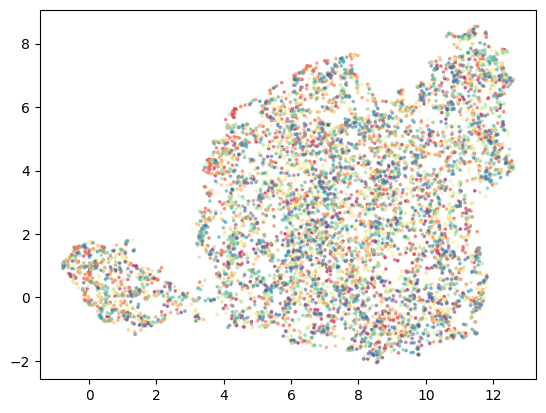

CPU times: user 1min 8s, sys: 2.06 s, total: 1min 10s
Wall time: 9.58 s


In [141]:
%%time
umap_model = umap.UMAP(
    n_neighbors=5,
    min_dist=.1,
    metric='cosine',
)
umap_embeds = umap_model.fit_transform(embeds, y=classes)

plt.scatter(
    *umap_embeds.T,
    s=3, 
    c=classes,
    cmap='Spectral',
    alpha=0.5)
plt.show()

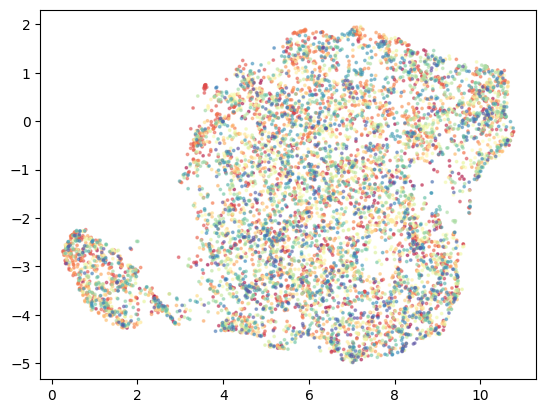

CPU times: user 1min 16s, sys: 1.92 s, total: 1min 18s
Wall time: 5.44 s


In [140]:
%%time
umap_model = umap.UMAP(
    n_neighbors=15,
    min_dist=.01,
)
umap_embeds = umap_model.fit_transform(embeds, y=classes)

plt.scatter(
    *umap_embeds.T,
    s=3, 
    c=classes,
    cmap='Spectral',
    alpha=0.5)
plt.show()

/home/dmarx/.local/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


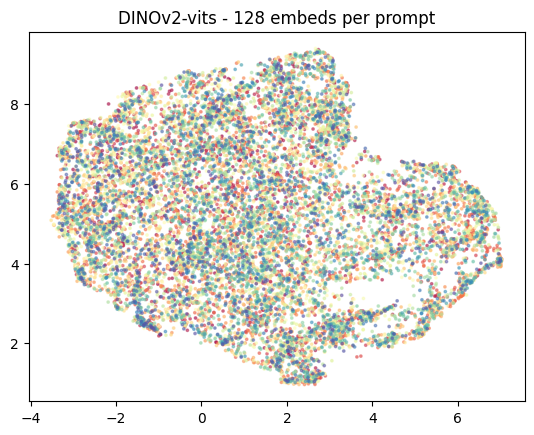

CPU times: user 1min 38s, sys: 3.55 s, total: 1min 42s
Wall time: 21.7 s


In [37]:
%%time

# vits

import umap

umap_model = umap.UMAP(
    n_neighbors=15,
    min_dist=.01,
)
umap_embeds = umap_model.fit_transform(embeds, y=classes)

plt.scatter(
    *umap_embeds.T,
    s=3, 
    c=classes,
    cmap='Spectral',
    alpha=0.5)
plt.title("DINOv2-vits - 128 embeds per prompt")
plt.show()


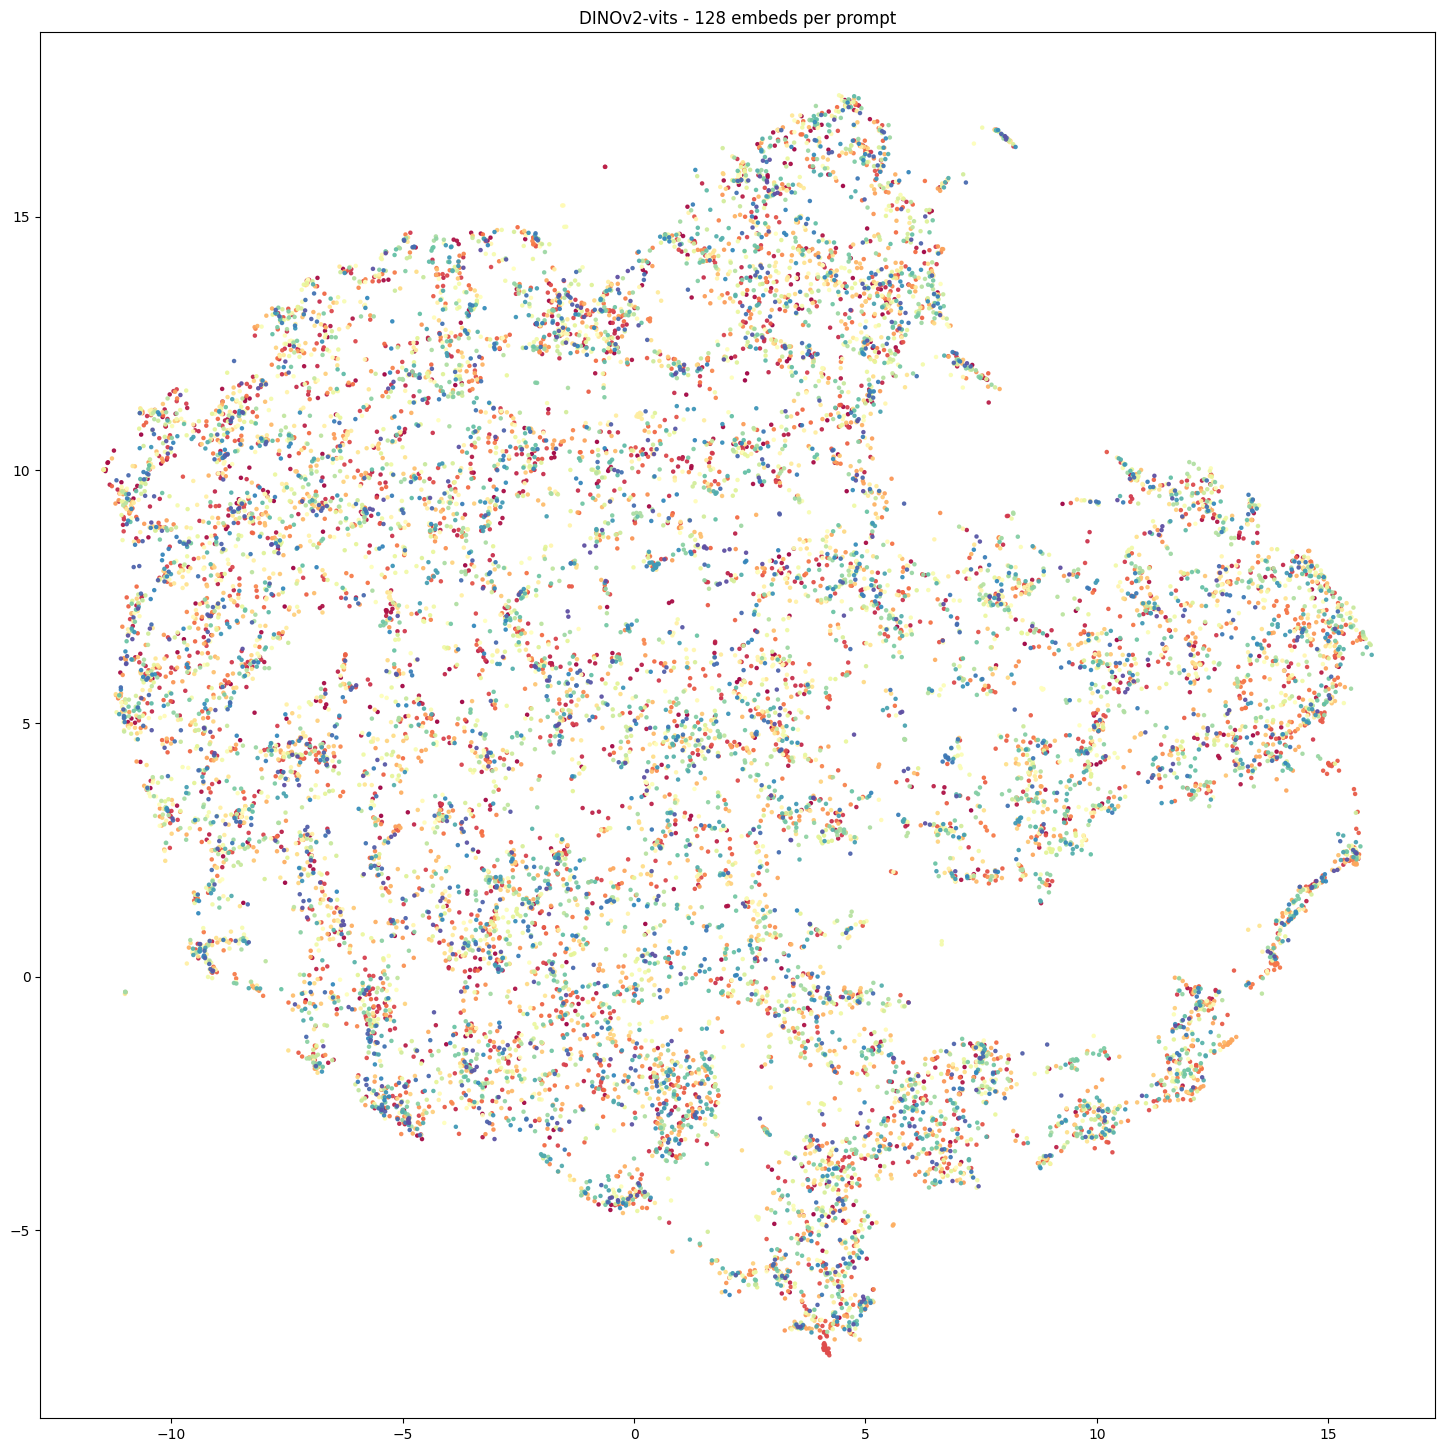

CPU times: user 1min 40s, sys: 2.99 s, total: 1min 43s
Wall time: 7.62 s


In [73]:
%%time

# vits

import umap

umap_model = umap.UMAP(
    n_neighbors=20,
    min_dist=.001,
    init='spectral',
    n_epochs=100,
    #local_connectivity=2,
    negative_sample_rate=20,
    repulsion_strength=1.5,
    #spread =1,
)
umap_embeds = umap_model.fit_transform(embeds, y=classes)

plt.scatter(
    *umap_embeds.T,
    s=5, 
    c=classes,
    cmap='Spectral',
    alpha=.9)
plt.title("DINOv2-vits - 128 embeds per prompt")

fig = plt.gcf()
fig.set_size_inches(18, 18)
plt.savefig("fml.png")

plt.show()


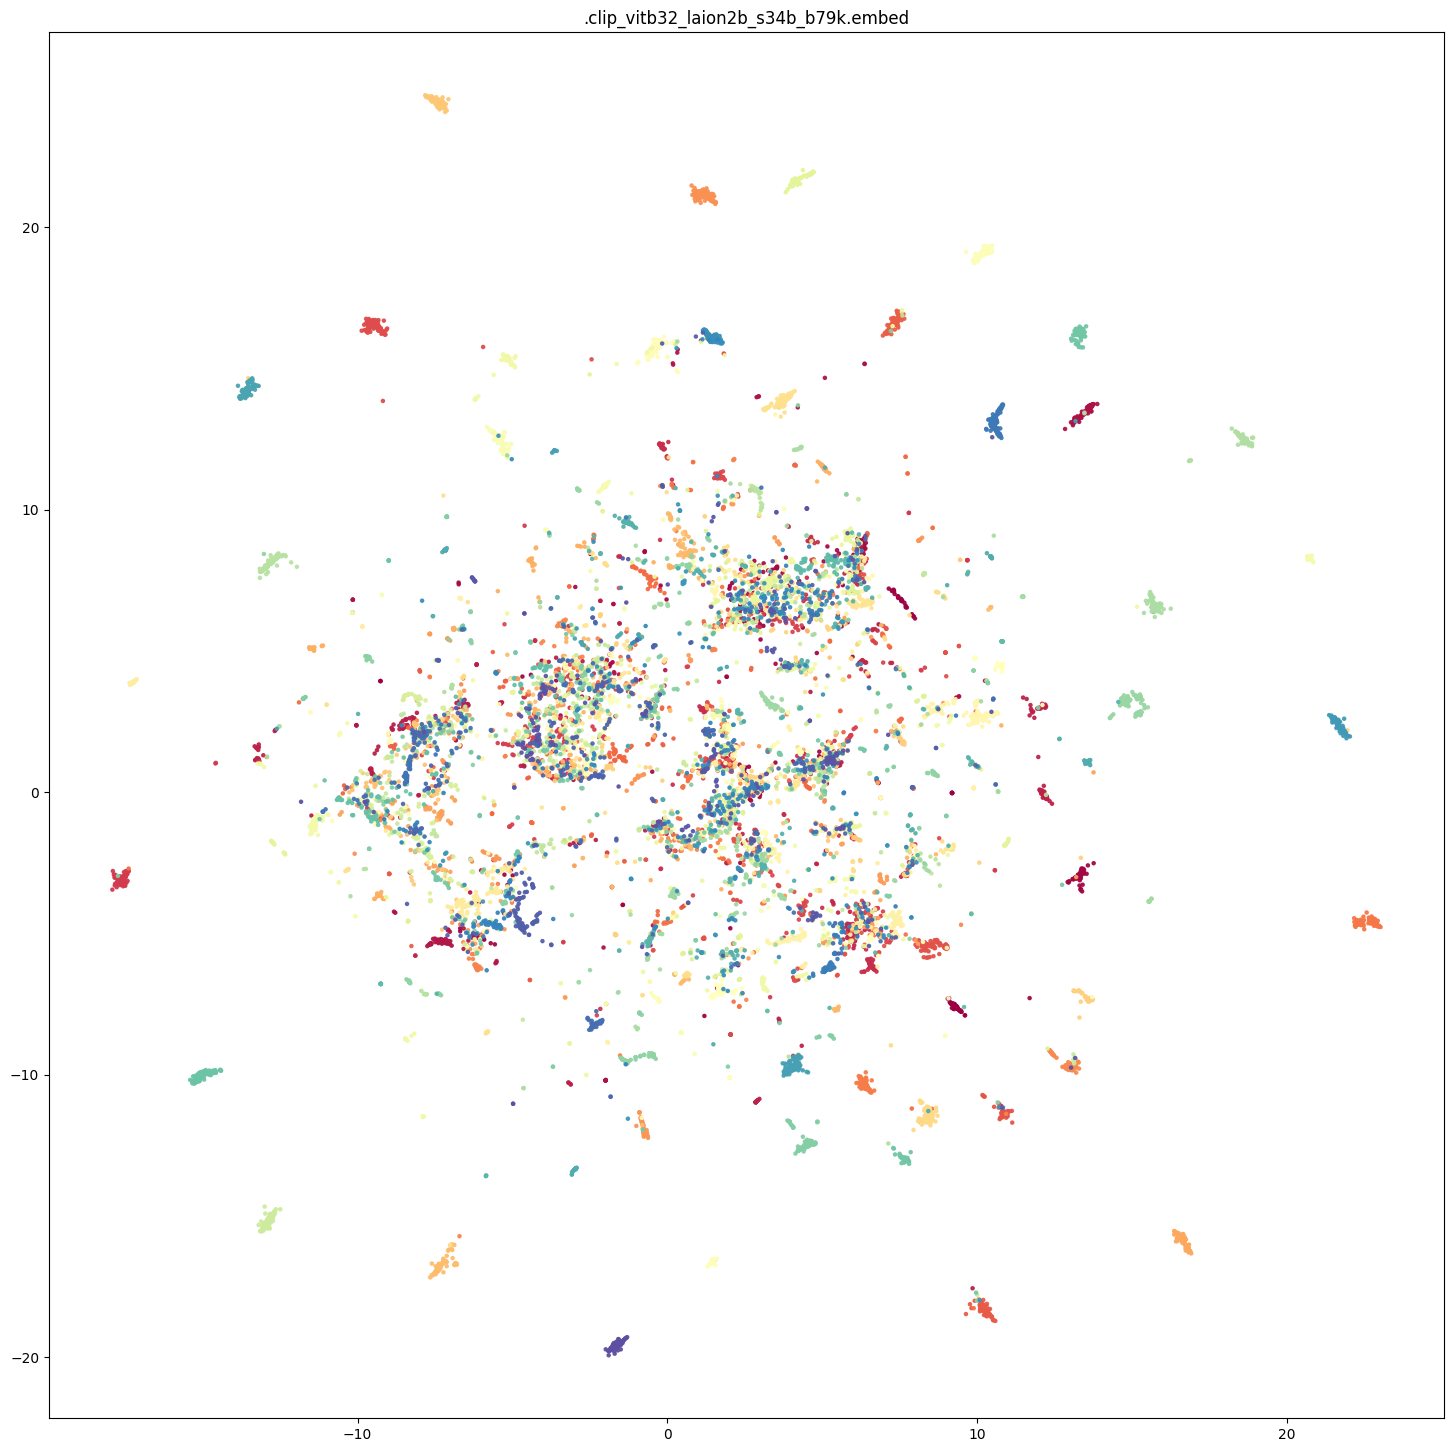

CPU times: user 1min 14s, sys: 11.4 s, total: 1min 25s
Wall time: 6.36 s


In [103]:
%%time

# vits

import umap

umap_model = umap.UMAP(
    n_neighbors=20,
    min_dist=.001,
    init='spectral',
    n_epochs=100,
    #local_connectivity=2,
    negative_sample_rate=20,
    repulsion_strength=1.5,
    #spread =1,
)
umap_embeds = umap_model.fit_transform(embeds, y=classes)

plt.scatter(
    *umap_embeds.T,
    s=5, 
    c=classes,
    cmap='Spectral',
    alpha=.9)
plt.title(f"{emb_suffix}")

fig = plt.gcf()
fig.set_size_inches(18, 18)
plt.savefig("clip-ftw.png")

plt.show()
# WAAAAAY better

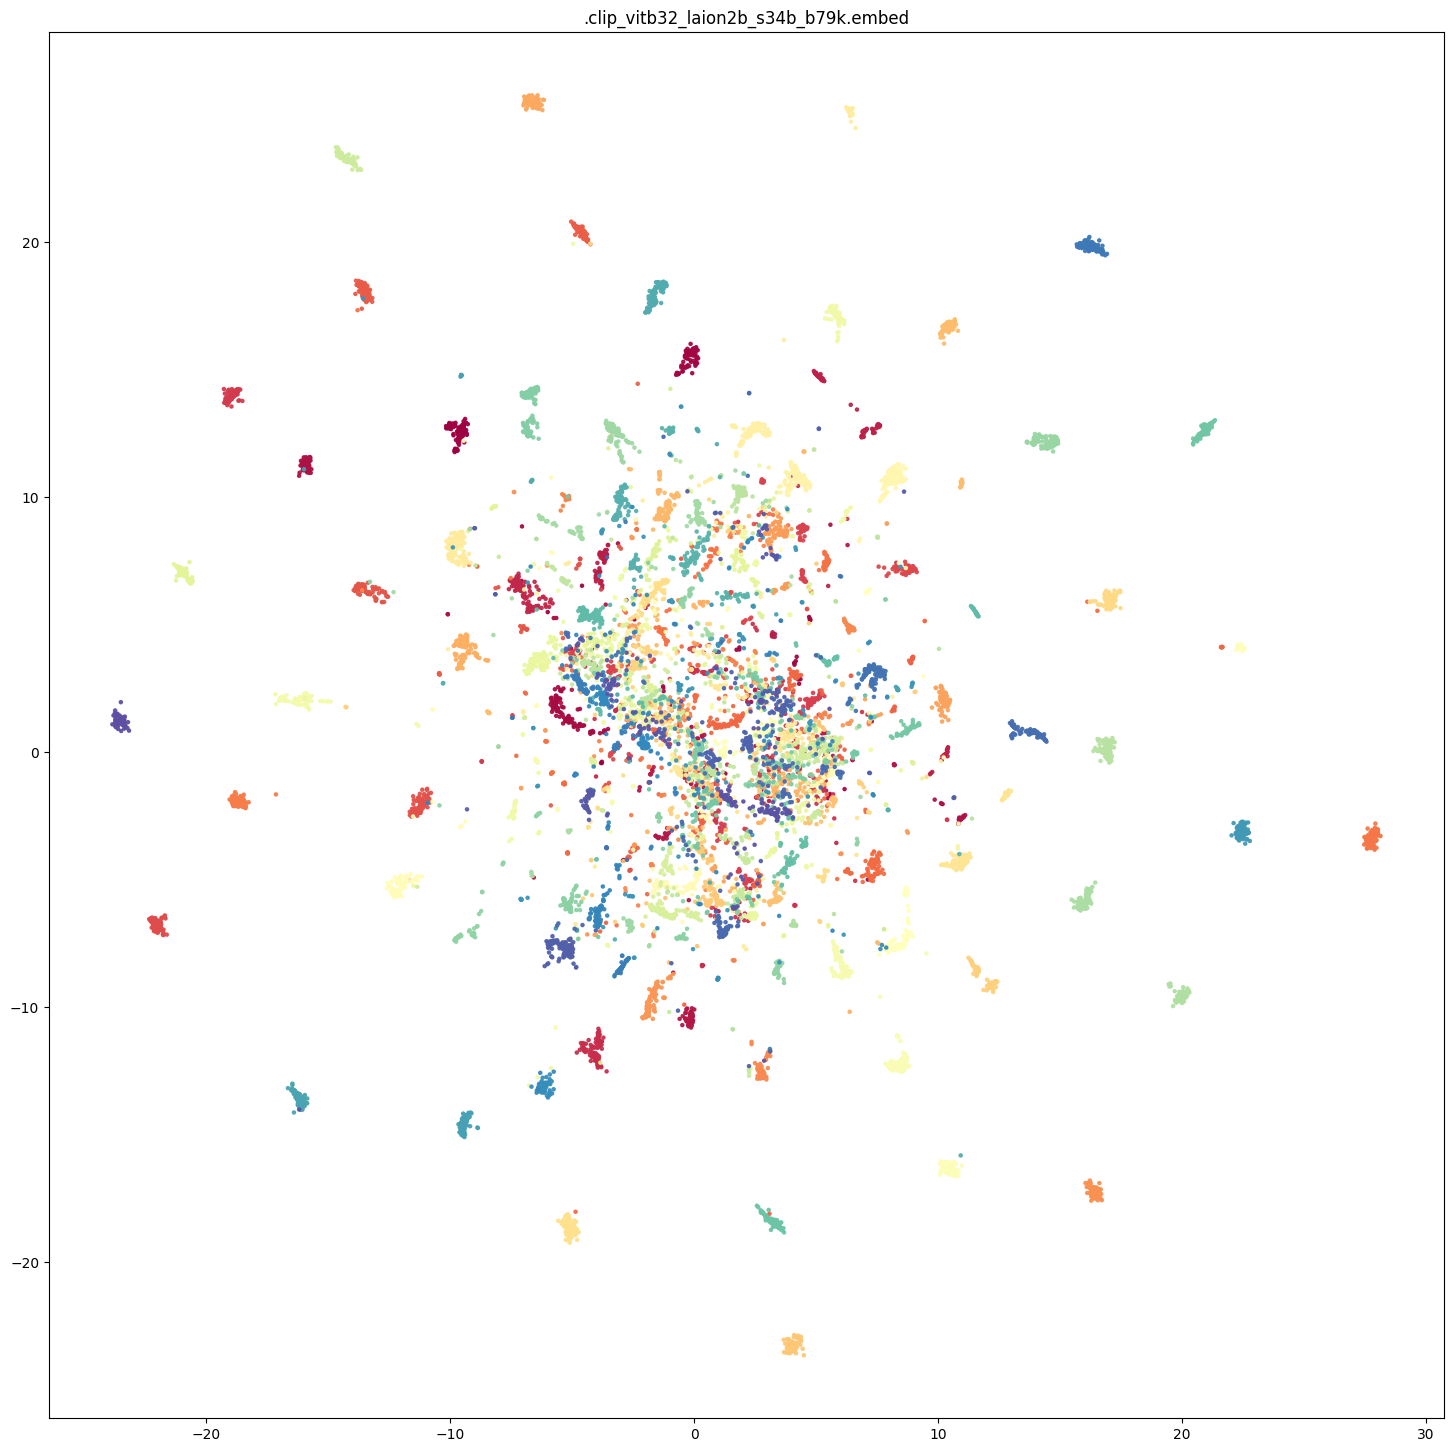

CPU times: user 2min 55s, sys: 27.2 s, total: 3min 22s
Wall time: 13.2 s


In [14]:
%%time

# vits

import umap

umap_model = umap.UMAP(
    n_neighbors=64, #20,
    #min_dist=.001,
    init='spectral',
    n_epochs=100,
    #local_connectivity=2,
    negative_sample_rate=20,
    repulsion_strength=1.5,
    #spread =1,
)
umap_embeds = umap_model.fit_transform(embeds, y=classes)

plt.scatter(
    *umap_embeds.T,
    s=5, 
    c=classes,
    cmap='Spectral',
    alpha=.9)
plt.title(f"{emb_suffix}")

fig = plt.gcf()
fig.set_size_inches(18, 18)
plt.savefig("clip-ftw.png")

plt.show()
# WAAAAAY better

Text(0.5, 1.0, '.clip_vitb32_laion2b_s34b_b79k.embed')

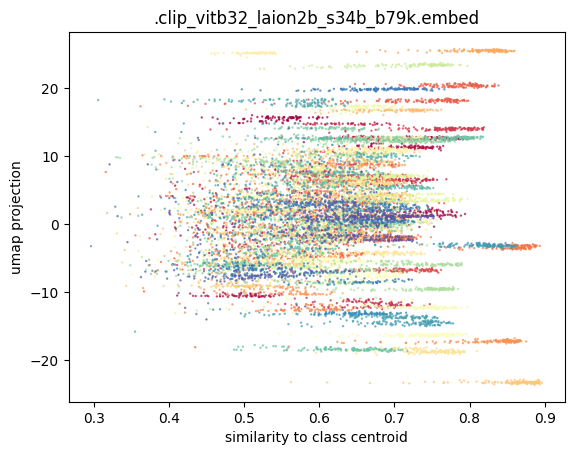

In [18]:


plt.scatter(
    inclass_similarities,
    umap_embeds[:,1],
    s=.5, 
    c=classes,
    cmap='Spectral',
    alpha=.7)
plt.xlabel('similarity to class centroid')
plt.ylabel('umap projection')
plt.title(f"{emb_suffix}")


In [80]:
# ok, so having confirmed that CLIP-ViTB/32 gets the job done here,
# let's re-calibrate the number of samples needed to estimate identity rigidity

# recs = []
# for k,v in embeds_cache.items():
#     rec = {'root':k}
#     break

# actually, fuck the embeds cache, let's build this object up from scratch.
# make it all nice n shit.

# ```

recs = []
for fpath in Path('images').rglob('*'):
    if not fpath.is_dir():
        continue
    if 'full_frame' not in str(fpath):
        continue
    if '.ipynb_checkpoints' in str(fpath):
        continue
    prefix='a_photo_of_'
    prompted_name = fpath.name[len(prefix):].split('_')[0]
    
    embed_paths = list(fpath.glob(f"*embed*.npy"))
    for epath in embed_paths:
        embed = np.load(epath)
        image_id, embed_type = epath.name.split('.',1)
        
        rec={
            'name':prompted_name,
            'root':fpath,
            'image_id':image_id,
            'embed_type':embed_type,
            'path':epath,
            'embed':embed,
            'embed_normed':embed / np.linalg.norm(embed),
        }
        recs.append(rec)

        
import pandas as pd
df_embeds = pd.DataFrame(recs)
        
        
#     S = []
#     for i in range(3, len(embeds)+1):
#         x = np.concatenate(embeds[:i])

#         # centroid similarity
#         mu = x.mean(0)
#         similarities = x@mu
#         S.append(similarities.mean())
    # x = np.concatenate(embeds)
    # mu = x.mean(0)
    # distances = x@mu
    # #similarities = 1 - distances
    # similarities = distances
    # diversity_score = similarities.mean()
    # #print(outdir)
    # #print((diversity_score, len(embeds)))
    # prompt_diversity[str(outdir)] = diversity_score
    # embeds_cache[str(outdir)] = deepcopy(embeds)
    # similarities_cache[str(outdir)] = deepcopy(similarities)

In [81]:
len(df_embeds), sum(df_embeds['embed_type'].str.contains('vitb32') )

(46181, 14993)

In [82]:
idx_clip = df_embeds['embed_type'].str.contains('vitb32')
df_clip = df_embeds[idx_clip]

In [84]:
# sanity check that we have one embed per image
#df_clip['image_id'].value_counts().value_counts()

# some variation, but we have at least 128 embeddings 
# for everything
df_clip['name'].value_counts().value_counts()

count
136    98
200     7
137     1
128     1
Name: count, dtype: int64

In [86]:
df_clip['name'].value_counts()

name
beyoncé      200
oprah        200
shaquille    200
rihanna      200
anupam       200
            ... 
naga         136
iko          136
justin       136
cristiano    136
bolo         128
Name: count, Length: 107, dtype: int64

In [102]:
len(df_name)
df_name.sample(3)['embed_normed'].sum() # .shape # 1, 512

(1, 512)

In [191]:
n_values

[32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128]

In [200]:
%%time
# this isn't the most efficient way to do this, but it'll
# at least make sense statistically and be easy to implement.
# 
# loop over each image, sample n images for same name,
# compute summary statistic at n
# compute for all n

n_values = list(range(32, 129, 8))

for v in n_values:
    col_name = f"similarity@{n}"
    if col_name not in df_clip.columns:
        df_clip.loc[:,col_name] = 0

#for name in df_clip['name'].unique():
# deepcopy so we can mutate df_clip
for name, df_name in deepcopy(df_clip).groupby('name'):
    print(name)
    for image_id in df_name['image_id']:
        #break
        df_rest = df_name[df_name['image_id']!=image_id]
        embed_i = df_name[df_name['image_id']==image_id]['embed_normed']
        # there's definitely a better way to do this...
        rec_idx = embed_i.index[0]
        embed_i = embed_i[embed_i.index[0]]
        
        #n=10
        def centroid_at_n(n):
            """
            samples n observations and returns their centroid
            """
            if n<len(df_rest):
                df_sample = df_rest.sample(n-1)
            else:
                df_sample = df_rest
            centroid = df_sample['embed_normed'].sum()
            if n<len(df_rest):
                centroid = centroid + embed_i # [embed_i.index[0]] #embed_i
            centroid = centroid / np.linalg.norm(centroid)
            return centroid
        
        #break

        
        for n in n_values:
            centroid = centroid_at_n(n)
            similarity = centroid @ embed_i.T
            
            col_name = f"similarity@{n}"
            df_clip.loc[rec_idx, col_name] = similarity
        
        #break
            

        
#name, image_id
#centroid = centroid_at_n(10)
#centroid @ embed_i.T
#centroid.shape, embed_i.shape


adele
amita
amol
angelina
anne
anupam
archie
bd
ben
beyoncé
billy
bolo
brad
brandon
brian
britney
bruce
celina
celine
cher
cristiano
dalip
dante
dave
david
davood
dennis
dev
devon
donnie
drake
dwayne
ed
ellen
elon
elton
ernie
george
geraldine
hailee
harrison
heung
himesh
howard
iko
james
jaycee
jennifer
jerry
johnny
judge
julia
justin
kanye
katy
keanu
kelly
kevin
kim
kobe
konnie
kunal
kylie
lady
lebron
leonardo
lilly
lionel
lou
madonna
mariah
meera
mel
michael
mindy
nadia
naga
neymar
nina
norah
oprah
parminder
pat
paul
rae
rick
rihanna
robert
robin
roger
rush
sandra
sanjeev
sarah
shaquille
simon
steven
sung
tatyana
taylor
tina
tom
tony
tyler
will
yayan
yuvraj
CPU times: user 2min 19s, sys: 12.1 ms, total: 2min 19s
Wall time: 2min 19s


In [152]:
df_clip.iloc[0]

name                                                         hailee
root              images/a_photo_of_hailee_portrait_photography_...
image_id                                               1695443826_6
embed_type                  clip_vitb32_laion2b_s34b_b79k.embed.npy
path              images/a_photo_of_hailee_portrait_photography_...
embed             [[0.16551183, 2.5595155, 0.46434936, 0.0950795...
embed_normed      [[0.015375791, 0.237775, 0.04313733, 0.0088327...
similarity@10                                                     0
similarity@32                                              0.827956
similarity@40                                              0.836711
similarity@48                                              0.835925
similarity@56                                                0.8392
similarity@64                                              0.835283
similarity@72                                              0.835385
similarity@80                                   

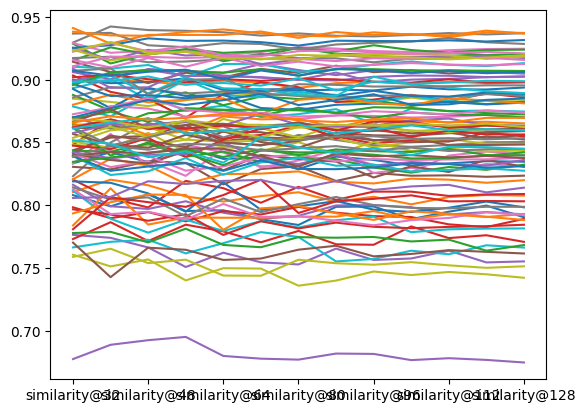

In [195]:
df_clip.columns[7:]
#df_clip.T[df_clip.columns[7:].values]
df_clip.head(100).T.loc[df_clip.columns[8:]].plot()
plt.gca().get_legend().remove()
# visually, looks like lower bound is at around 80
# also, stronger identities appear to have stabler similarity measures, as we'd expect

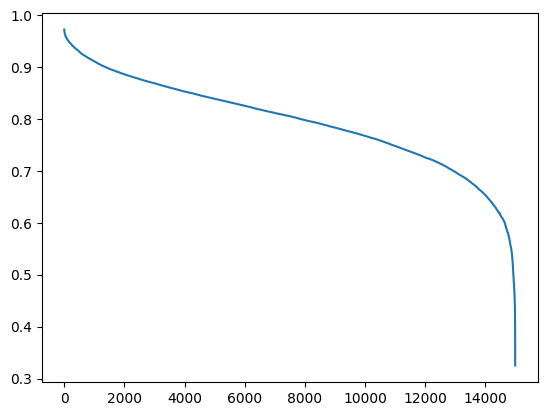

In [196]:
arr = df_clip['similarity@128'].values
arr.sort()
plt.plot(arr[::-1])

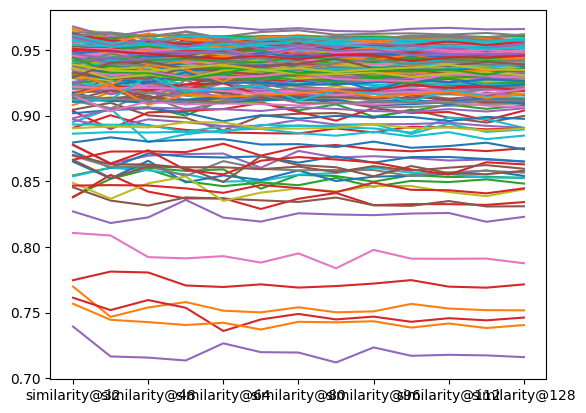

In [201]:
df_clip[df_clip['name']=='rihanna'].T.loc[df_clip.columns[8:]].plot()
plt.gca().get_legend().remove()

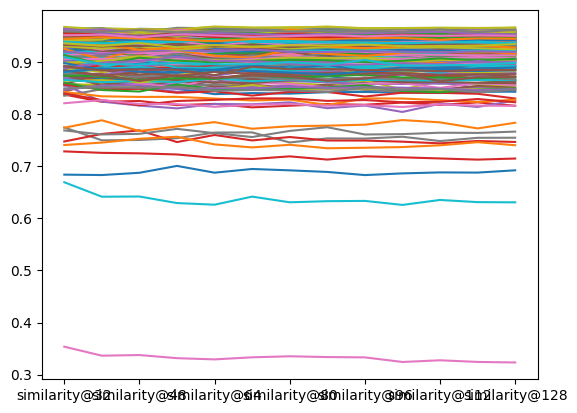

In [202]:
df_clip[df_clip['name']=='oprah'].T.loc[df_clip.columns[8:]].plot()
plt.gca().get_legend().remove()

In [ ]:
# I should probably just calculate the variance at each n, since i'm mostly interested
# in the convergence of this measure anyway.

# TODO

* [ ] filtter out images with more than one face in them (check and report on what gets pulled out)
* [x] calibrate # images for experiments
  * "power analysis" - how many images do we need to detect the variance threshold we're interested in?"
  * going with 64 as a rough ultra-lower bound for now.
* [x] DINOv2 embeddings
  * got it configured for the smallest model, let's try using the largest my card will tolerate.
  * [x] smallest model
  * [x] largest model
* [ ] image dataloader
  * even batch loading just to estimate embeddings would be nice
* [ ] embeddings dataloader
* [ ] CLIP embeddings
  * [x] vit-b-32
  * [ ] vit-l-14
  * [ ] eva-02-?
* [ ] unCLIP embeddings
* [ ] upload datasets to HF
  * https://huggingface.co/docs/datasets/upload_dataset
  * [ ] images
  * [ ] small DINO embeds
  * [ ] large DINO embeds
* [x] per-prompt (cluster) summary statistics
* [ ] identity-preserving contrastive encoder
* Visualizations
  * [x] tSNE embeds
  * [x] tSNE-> 1st PC vs. Diversity Score
  * [ ] Nomic Embedding Atlas
  * [x] supervised-umap
    * https://umap.scikit-tda.org/supervised.html#using-labels-to-separate-classes-supervised-umap
    * https://umap.scikit-tda.org/supervised.html#training-with-labels-and-embedding-unlabelled-test-data-metric-learning-with-umap
* [ ] separately generate and save input clip embeddings of prompts
* [x] score images relative to centroid in addition to summary statistic for cluster
  * need a better cluster summary statistic first
* [ ] repeat procedure across several checkpoints, compare per-cluster summary statistics across checkpoints. expect to observe narrowing of biases as checkpoints are progressively finetuned.